# Global Optimization with Gaussian Processes: Part1

The goal of this notebook is to illustrate the basic concepts of Bayesian optimization using Gausian Processes. We will focus on two aspects of Bayesian Optimization (BO): (1) the choice of the model (2) the choice of the acquisition function.

## 1. Getting started

This lab uses [GPyOpt](http://sheffieldml.github.io/GPy/), a satellite module of GPy (a Gaussian Processs framework for ML tasks) useful to solve global optimization problems. The current version of Gpy has compatibility issues with matplotlib versions > 3.4.0, so please be sure that it is correctly installed using the following commands before starting. The easiest way is using pip. In Ubuntu machines you can do:

In [3]:
#!pip install git+https://github.com/jdariasl/GPy.git
#!pip install GPyOpt==1.2.1

Let's import the required libraries.

In [1]:
%matplotlib inline  
import GPy
import GPyOpt
import numpy as np
from numpy.random import seed
seed(12345)

### Remembering the basics

Before starting with the lab, remember that (BO) is an heuristic for global optimization of black-box functions. Let $f: {\mathcal X} \to R$ be a 'well behaved' continuous function defined on a compact subset ${\mathcal X} \subseteq R^d$. Our goal is to solve the global optimization problem of finding
$$ x_{M} = \arg \min_{x \in {\mathcal X}} f(x). $$

We assume that $f$ is a *black-box* from which only perturbed evaluations of the type $y_i = f(x_i) + \epsilon_i$, with $\epsilon_i \sim\mathcal{N}(0,\sigma^2)$, are  available. The goal is to find $x_M$ by minimizing the number of evaluations of $f$. To do this, we need to determine two crucial bits:

1. A **Gaussian process** that will capture the our beliefs on $f$. 

2. An **acquisition function** that based on the model will be useful to determine where to collect new evaluations of f. 

Remember that every time a new data point is collected the model is updated and the acquisition function optimized again. 

### Running example

We start with a one-dimensional example. Consider here the Forrester function 

$$f(x) =(6x-2)^2 \sin(12x-4),$$ defined on the interval $[0, 1]$. 

The minimum of this function is located at $x_{min}=0.78$. We assume that the evaluations of $f$ to are perturbed by zero-mean Gaussian noise with standard deviation 0.25. The Forrester function is part of the benchmark of functions of GPyOpt. To create the true function, the perturbed version and the boundaries of the problem you need to run the following cell. 

In [16]:
# Create the true and perturbed Forrester function and the boundaries of the problem
f_true= GPyOpt.objective_examples.experiments1d.forrester()          # noisy version
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]  # problem constraints 

To plot the true $f$, simply write:

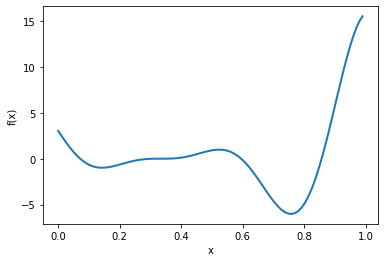

In [17]:
f_true.plot()

f_true contains the function that we are going to optimize. You can define your own objective but it should be able to map any numpy array of dimension $n\times d$ (inputs) to a numpy array of dimension $n\times 1$ (outputs). For instance:

In [18]:
n = 8
x = np.random.rand(n).reshape(n,1)
x

array([[0.20504307],
       [0.26266331],
       [0.53858886],
       [0.94046986],
       [0.23311675],
       [0.04730537],
       [0.77645205],
       [0.50794296]])

In [19]:
f_true.f(x)

array([[-0.59221162],
       [-0.13484224],
       [ 0.95193503],
       [11.18398532],
       [-0.3373284 ],
       [ 0.84429198],
       [-5.81391931],
       [ 0.9500325 ]])

To use BO to solve this problem, we need to create a GPyOpt object in which we need to specify the following elements: 
* The function to optimize.
* The box constrains of the problem.
* The model, that is fixed by default to be a GP with a SE kernel.
* The acquisition function (and its parameters).

We create an SE kernel as we do in GPy

In [20]:
k = GPy.kern.RBF(1)

And now we have all the elements to start optimizing $f$. We create the optimization problem instance. Note that you don't need to specify the evaluation budget of. This is because at this stage we are not running the optimization, we are just initializing the different elements of the BO algorithm. 

In [21]:
# Creates GPyOpt object with the model and anquisition fucntion
seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=f_true.f,            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             initial_design_numdata=3,
                                             kernel = k,
                                             exact_feval = True) # Selects the Expected improvement

In [22]:
?GPyOpt.methods.BayesianOptimization

At this point you can access to a number of elements in myBopt, including the GP model and the current dataset (initialized at 3 random locations by default).

In [23]:
myBopt.X

array([[0.69646919],
       [0.28613933],
       [0.22685145]])

In [24]:
myBopt.Y

array([[-4.45162646],
       [-0.04302052],
       [-0.39078442]])

In [25]:
myBopt.model.kernel

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


The noise variance is automatically bounded to avoid numerical problems. In case of having a problem where the evaluations of $f$ are exact you only need to include 'exact_feval=True' when creating the BO object as above. Now, to run the optimization for certain number of iterations you only need to write:

In [26]:
# Run the optimization
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps)   

And that's it! You should have receive a message describing if the method converged (two equal x's are selected in consecutive steps of the optimization) or if the maximum number of iterations was reached. In one dimensional examples, you can visualize the model and the acquisition function (normalized between 0 and 1) as follows.

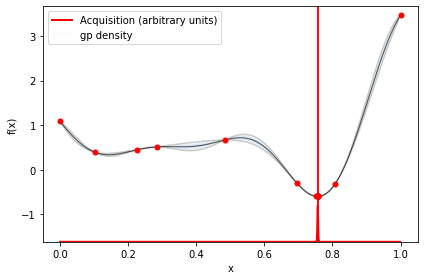

In [27]:
myBopt.plot_acquisition()

You can only make the previous plot if the dimension of the problem is 1 or 2. However, you can always how the optimization evolved by running:

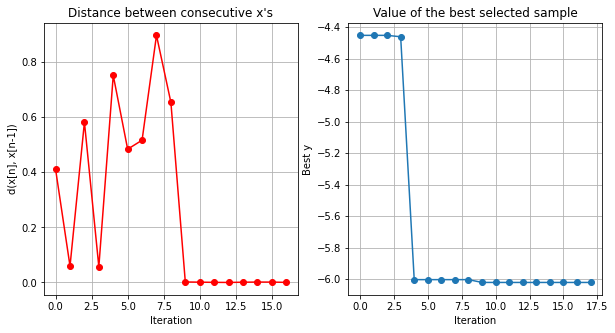

In [13]:
myBopt.plot_convergence()

The first plot shows the distance between the last two collected observations at each iteration. This plot is useful to evaluate the convergence of the method. The second plot shows the best found value at each iteration. It is useful to compare different methods. The fastest the curve decreases the best is the method. The last one shows the predicted sdev. at the next location. This plot is useful to study the exploration/exploitation that is carried out at each step of the optimization. See how the method converged after 10 iterations. You can also print the updated GP

In [14]:
myBopt.model.model

GP_regression.,value,constraints,priors
rbf.variance,3.522037639136576,+ve,
rbf.lengthscale,0.17550907043767763,+ve,
Gaussian_noise.variance,1e-06,+ve fixed,


### Exercise 1

Use Bayesian optimization to find the minimum of the function $f(x)= x^2 + 10 \sin(x)$ in the interval [-10, 10]. 

1.1 Define the bounds of the problem, the function and check that it admits a numpy array of observations as input.

In [19]:
# Answer to 1.1 here:




1.2 Create a GPyOpt object for global optimization using a Mattern52 kernel.

In [20]:
# Answer to 1.2 here:




1.3 Run the optimization for 10 iterations. Make and comment the convergence plots. Has the method converged? 

In [22]:
# Answer to 1.3 here:





### Exercise 2

Consider the sixhumpcamel function defined as
$$f(x_1,x_2) = \left(4-2.1x_1^2 + \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-2,2]\times [-1,1]$. This function has two global minima, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. This function is also implemented in GPyOpt so, to load and visualize it simply run.

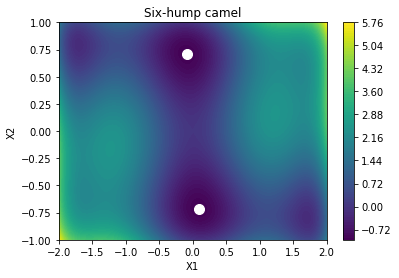

In [49]:
GPyOpt.fmodels.experiments2d.sixhumpcamel().plot()
f_shc = GPyOpt.fmodels.experiments2d.sixhumpcamel(sd = 0.1).f  # simulated version with some noise
bounds_shc = GPyOpt.fmodels.experiments2d.sixhumpcamel().bounds

2.1 Create three objects to optimize this function using the the 'EI' and 'MPI'. Use the same initial data in the three cases (Hint: use the options 'X' and 'Y' when creating the BO object).

In [31]:
# Answer to 2.1






2.2 In the two cases run the optimization for 30 iterations

In [32]:
# Answer to 2.2 here:






2.3 Now make a plot comparing the two methods. The x axis should contain the number of iterations and y axis the best found value (Hint: use .Y_best to extract from the BO objects the best current value at each iteration). Which acquisition has the best performance in this example?

In [33]:
# Answer to 2.3 here:






2.4 Compare the models and the acquisition functions in the two cases (after the 30 iterations). What do you observe? 

In [ ]:
# Answer to 2.4 here:



